In [1]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from  torch.optim import Adam
from matplotlib import pyplot as plt
%matplotlib inline

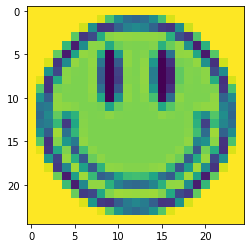

In [3]:
# Based on Berkley DeepUL Code
from PIL import Image
image_path = "./smiley.jpg"
dimension = 25

def load_image(image_path: str, dimension: int):
    with Image.open(image_path) as image:
        image = image.resize((dimension,dimension))
        image = image.convert("L")
        return np.array(image)

def sample_from_image(image: np.ndarray, total_samples: int):
    from itertools import product
    height, width = image.shape

    x1, x2  = np.arange(height), np.arange(width)

    combined = list(product(x1, x2))

    image_distribution = image.reshape(-1,) / image.sum()

    choices = np.random.choice( len(combined), size = total_samples, p = image_distribution)

    return np.array([ combined[choice] for choice in choices])

loaded_image = load_image(image_path, dimension)

plt.imshow(loaded_image)

In [4]:
total_samples = 2500
sampled_data = sample_from_image(loaded_image, total_samples)

print(f"Sample size: {len(sampled_data)}")

Sample size: 2500


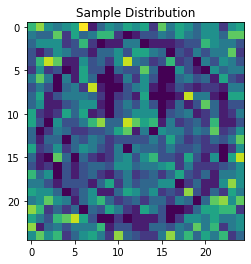

In [5]:
def plot_samples_distribution(samples: np.ndarray, dimension: int):
    data = np.zeros((dimension, dimension))
    plt.figure()

    plt.title("Sample Distribution")

    for sample in samples:
        x,y = sample
        data[x][y] += 1

    plt.imshow(data)
    plt.show()

plot_samples_distribution(sampled_data, dimension)

In [6]:
from torch.utils.data import DataLoader, Dataset

class NumpyDataset(Dataset):
    def __init__(self, samples: np.ndarray, transform = None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        item = self.samples[index]

        if self.transform is not None:
            return self.transform(item)

        return item

# dataset = NumpyDataset(sampled_data)
# data_loader = DataLoader(dataset, batch_size=128,shuffle=True)

# for samples in data_loader:
#     print(samples[0])
#     print( len(samples))

In [7]:
def plot_density(density: torch.Tensor, epoch: int):
    plt.figure()
    plt.title( f"Epoch: {epoch}, Learned Density")
    plt.imshow(density)
    plt.show()

In [8]:
class SimpleAutoRegressiveModel(nn.Module):
    # p(x0, x1) = p(x0) * p(x1|x0)
    # p(x0) -> histogram
    # p(x1 | x0) -> mlp
    def __init__(self, dimension: int, device="cpu"):
        super(SimpleAutoRegressiveModel, self).__init__()
        self.dimension = dimension

        self.device = device

        self.hidden_nodes = 50

        self.x0_logits = nn.Parameter(torch.zeros(self.dimension))

        self.x1_mlp = nn.Sequential(
            nn.Linear(self.dimension, self.hidden_nodes),
            nn.ReLU(),
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(),
            nn.Linear(self.hidden_nodes, self.dimension),
        )

    def negative_log_likelihood(self, x : torch.Tensor) -> torch.Tensor:
        x0, x1 = x [ : , 0], x[ : , 1]

        # fit histogram from x0 in logits
        x0_logits = self.x0_logits.unsqueeze(dim=0)
        x0_logits = x0_logits.repeat(x0.shape[0], 1)
        x0_ce_loss = F.cross_entropy(x0_logits, x0.long())

        #print(f"Histogram loss: {x0_ce_loss}")

        x0_one_hot = F.one_hot(x0.long(), self.dimension).float()
        mlp_output = self.x1_mlp(x0_one_hot)
        x1_ce_loss = F.cross_entropy(mlp_output, x1.long())

        #print(f"Mlp loss: {x1_ce_loss}")

        return x0_ce_loss + x1_ce_loss

    def get_density(self) -> torch.Tensor:

        with torch.no_grad():
            x0  = self.x0_logits.unsqueeze( dim = 0 ).repeat(self.dimension, 1)
            prob_x0 = F.softmax(x0, dim=0 )

            mlp_one_hot : torch.Tensor = F.one_hot( torch.arange(self.dimension), self.dimension)

            x1 = self.x1_mlp.forward(mlp_one_hot.float())
            prob_x1 = F.softmax(x1, dim=1)

            return prob_x0 * prob_x1

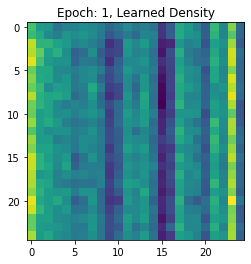

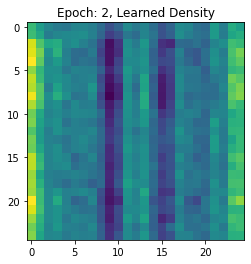

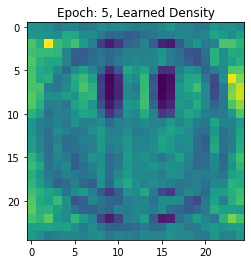

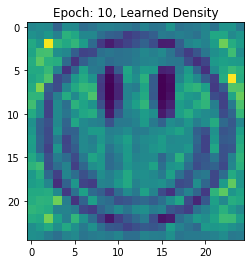

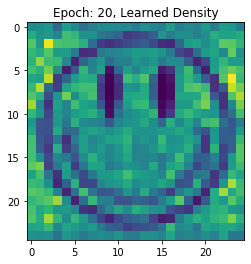

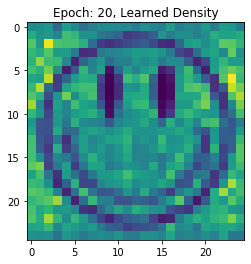

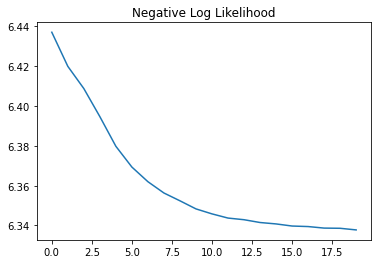

In [9]:
from typing import List

total_epoch = 20
total_samples = 25000

model = SimpleAutoRegressiveModel(dimension)
optimizer = Adam(model.parameters(), lr = 0.001)

sampled_data = sample_from_image(loaded_image, total_samples)

dataset = NumpyDataset(sampled_data)
data_loader = DataLoader(dataset, batch_size=512, shuffle=True)

def train(model: nn.Module, optimizer: torch.optim.Optimizer, data_loader: DataLoader):
    losses = []
    for samples in data_loader:
        optimizer.zero_grad()
        loss = model.negative_log_likelihood(samples)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

losses = []

for epoch in range(1, total_epoch + 1):

    epoch_loss = train(model, optimizer, data_loader)

    losses.append(epoch_loss)
    
    if epoch in [1,2,5,10,20]:
        density = model.get_density()
        plot_density(density, epoch)

density = model.get_density()
plot_density(density, epoch)

def plot_loss(losses: List[float] ):

    plt.figure()
    plt.title("Negative Log Likelihood")
    plt.plot(np.arange(len(losses)), losses )

    plt.show()

plot_loss(losses)